In [ ]:
from surprise.model_selection import train_test_split, KFold

# 1. Importing & EDA (Pandas)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
ratings_df = pd.read_csv('data/ratings.csv')
ratings_df.drop('timestamp', axis=1, inplace=True)

In [3]:
print('Number of Users = ', len(ratings_df['userId'].unique()))
print('Number of Movies = ', len(ratings_df['movieId'].unique()))
print(ratings_df.shape)

Number of Users =  610
Number of Movies =  9724
(100836, 3)


In [4]:
ratings_df.describe()

,userId,movieId,rating
count,100836.000000,100836.000000,100836.000000
mean,326.127564,19435.295718,3.501557
std,182.618491,35530.987199,1.042529
min,1.000000,1.000000,0.500000
25%,177.000000,1199.000000,3.000000
50%,325.000000,2991.000000,3.500000
75%,477.000000,8122.000000,4.000000
max,610.000000,193609.000000,5.000000


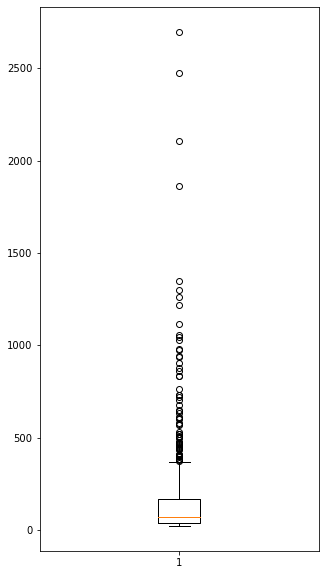

In [5]:
user_rating_count = ratings_df['userId'].value_counts()

fig, ax = plt.subplots(figsize=(5,10))
plt.boxplot(user_rating_count);

In [6]:
user_rating_count

414    2698
599    2478
474    2108
448    1864
274    1346
       ... 
406      20
595      20
569      20
431      20
442      20
Name: userId, Length: 610, dtype: int64

# 2. Exploring Model-Based Methods 

1. I am choosing a model-based method over memory-based methods due to the size (100,000 entries) of the dataset
2. I will start by building a Collaborative Filtering recommender system
    - Predictor algorithm will be chosen upon the lowest RMSE score 

In [7]:
import numpy as np
from surprise import Reader, Dataset
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise.model_selection import KFold
from surprise.prediction_algorithms import BaselineOnly, SVD, SVDpp, NMF, SlopeOne, CoClustering

In [8]:
reader = Reader()
data = Dataset.load_from_df(ratings_df, reader)

In [ ]:
def predictor_RMSE(pred, data, cv=None, njobs=0):
    """
    if 'cv' parameter not specified, cv = 5
    
    """
    pred_base = pred()
    cv_pred = cross_validate(pred_base, data, cv=cv, n_jobs=njobs)
    
    print(np.mean(cv_pred['test_rmse']))
    
    

In [ ]:
predictor_RMSE(BaselineOnly, data, njobs=-1)

In [ ]:
predictor_RMSE(SVD, data, njobs=-1)

In [ ]:
# predictor_RMSE(SVDpp, data, njobs=-1)

In [ ]:
predictor_RMSE(NMF, data, njobs=-1)

In [ ]:
predictor_RMSE(SlopeOne, data, njobs=-1)

In [ ]:
predictor_RMSE(CoClustering, data, njobs=-1)

**OBSERVATION**
1. BaselineOnly and SVD continuously get very close results, with the lower of the two alternating constantly
2. BaselineOnly (along with all other baselines included in Surprise) use ALS as the default
    - this could explain the baseline's comparable results to SVD

### Optimizing SVD

In [ ]:
param_grid = {'n_factors':[50, 100, 150],
              'n_epochs': [10, 20, 30]}

svd_grid = GridSearchCV(SVD, param_grid=param_grid, n_jobs=-1)
svd_grid.fit(data)

In [ ]:
print(svd_grid.best_score)
print(svd_grid.best_params)

In [ ]:
param_grid = {'n_factors':[10, 25, 50],
              'lr_all': [0.002, 0.005],
              'reg_all': [0.02, 0.1, 0.2]}

svd_grid = GridSearchCV(SVD, param_grid=param_grid, n_jobs=-1)
svd_grid.fit(data)

In [ ]:
print(svd_grid.best_score)
print(svd_grid.best_params)

# 3. Making Predictions 

In [ ]:
dataset = data.build_full_trainset()

In [ ]:
dataset = data.build_full_trainset()

svd = SVD(n_factors=10, lr_all = 0.005, reg_all=0.02)
svd.fit(dataset)

In [ ]:
svd.predict(5, 10)

# 3. Recommendations For Preexisting Users

# 4. Addressing 'Cold-Start' Problem

In [9]:
#importing movie titles
title_df = pd.read_csv('data/movies.csv')

#merging ratings and titles
title_rating_df = pd.merge(ratings_df, title_df, on='movieId')

#creating groupby by title and genres
rating_count_df = title_rating_df.groupby(by=['title', 'genres', 'movieId'])

#aggregating the number of ratings for each title 
rating_count_df= rating_count_df['rating'].count().reset_index().rename(columns = {'rating': 'rating_count'})

#display in descending order based on rating_count
rating_count_df = rating_count_df.sort_values(by='rating_count', ascending=False)

#SOURCE FOR CODE
#https://www.youtube.com/watch?v=kccT0FVK6OY&list=PL-IOEPSNs4rYKHhicQ210AXk5yuzrkeH1&index=12&ab_channel=KrishNaik

In [10]:
rating_count_df.head()

,title,genres,movieId,rating_count
3161,Forrest Gump (1994),Comedy|Drama|Romance|War,356,329
7597,"Shawshank Redemption, The (1994)",Crime|Drama,318,317
6868,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,296,307
7684,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,593,279
5515,"Matrix, The (1999)",Action|Sci-Fi|Thriller,2571,278


In [11]:
import re 

In [12]:
def movie_rater():
    #creating new userId to be appended to the end of ratings_df
    userId = ratings_df['userId'].max() + 1
    rating_list = []
    
    #collecting genre preferences
    #DISPLAY A LIST OF ALL GENRES AVAILABLE? 
    top_genres = []
    top_genres.append(input('What is your favorite movie genre?'))
    top_genres.append(input('What is your SECOND favorite movie genre?'))
    least_fav_genre = input('What is your LEAST favorite movie genre?')
    
    print('----------------------------------------------')
    print('You will now be shown 5 {} and {} movies, please rate them from 0.5 - 5'.format(top_genres[0], top_genres[1]))
    print('If you have not seen the given movie, please enter n')
    
    #Prompting the user to rate 5 MOST VIEWED movies of their preferred genres
    num = 5
    index = 0
    while num > 0:
        movie_df = rating_count_df[(rating_count_df['genres'].str.contains(top_genres[0])) 
                                & (rating_count_df['genres'].str.contains(top_genres[1]))]
        movie_df[(~movie_df['genres'].str.contains(least_fav_genre))]
        print('----------------------------------------------')
        
        movie = movie_df.iloc[index]
        print(movie)
        #ADD ERROR FOR INVALID INPUTS?
        rating = float(input('How do you rate this movie? Press n if you have not seen it'))
        if rating == 'n':
            index += 1
            continue 
        else: 
            # rated_movie is what gets appended to the ratings_df (what model is run on)
            rated_movie = {'userId':userId, 'movieId':movie['movieId'], 'rating':rating}
            rating_list.append(rated_movie)
            num -= 1
            index += 1
            
    #adding new user ratings (rating_list) to original ratings dataframe (ratings_df)
    ratings_df.append(rating_list, ignore_index=True)
    
    new_data = Dataset.load_from_df(ratings_df, reader)
    
    #training new model on updated_ratings_df
    svd = SVD(n_factors=10, lr_all = 0.005, reg_all=0.02)
    svd.fit(new_data.build_full_trainset())

    
    #running model to predict new movies for user 
    
    movie_recs = []
    for m_id in ratings_df['movieId'].unique():
        movie_recs.append( (m_id,svd.predict(500,m_id)[3]))

    
    print('----------------------------------------------')
    
    #displaying 5 recommendations
    print('We made 5 recommendations for you!')
    
    ranked_movies = sorted(movie_recs, key=lambda x:x[1], reverse=True)

    n = 5
    rec_list = []
    for idx, rec in enumerate(ranked_movies):
        title = title_df.loc[title_df['movieId'] == int(rec[0])]['title']
        rec_list.append(title)
        print('Recommendation # ', idx+1, ': ', title, '\n')
        n -= 1
        if n == 0:
            break
    
    print('----------------------------------------------')
    
    #Continue rating or stop
    print('The more movies you rate, the better recommendations we can make!')
    
    second_round_rating = input('Would you like to coninue rating? [y/n]')
    if second_round_rating == 'n':
        print('Thank you for participating in Jack\'s Phase 4 Project =D')
    

    rec_list
    #ranked_movies_df = pd.DataFrame(ranked_movies[:5])
    
    
    
#     rating_list = []
#     num = 5
#     index = 0
#     while num > 0:
#         movie = ranked_movies[index]
#         print(movie)
#         rating = float(input('How do you rate this movie? Press n if you have not seen it'))
#         if rating == 'n':
#             index += 1
#             continue 
#         else: 
#             rated_movie = {'userId':userId, 'movieId':movie['movieId'], 'rating':rating}
#             rating_list.append(rated_movie)
#             num -= 1
#             index += 1
        
        
         
        
    
    
            
                    

In [13]:
rating_count_df

,title,genres,movieId,rating_count
3161,Forrest Gump (1994),Comedy|Drama|Romance|War,356,329
7597,"Shawshank Redemption, The (1994)",Crime|Drama,318,317
6868,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,296,307
7684,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,593,279
5515,"Matrix, The (1999)",Action|Sci-Fi|Thriller,2571,278
...,...,...,...,...
4774,King Ralph (1991),Comedy,7005,1
4772,King Kong Lives (1986),Adventure|Sci-Fi,2368,1
4767,"Kindred, The (1986)",Horror|Sci-Fi,2740,1
4766,Kindergarten Cop 2 (2016),Action|Comedy,158254,1


In [14]:
userId = ratings_df['userId'].max() + 1
rating_list = []
    
    #collecting genre preferences
    #DISPLAY A LIST OF ALL GENRES AVAILABLE? 
top_genres = []
top_genres.append(input('What is your favorite movie genre?'))
top_genres.append(input('What is your SECOND favorite movie genre?'))
least_fav_genre = input('What is your LEAST favorite movie genre?')
    
print('----------------------------------------------')
print('You will now be shown 5 {} and {} movies, please rate them from 0.5 - 5'.format(top_genres[0], top_genres[1]))
print('If you have not seen the given movie, please enter n')
    
    #Prompting the user to rate 5 MOST VIEWED movies of their preferred genres
num = 5
index = 0
while num > 0:
        movie_df = rating_count_df[(rating_count_df['genres'].str.contains(top_genres[0])) 
                                & (rating_count_df['genres'].str.contains(top_genres[1]))]
        movie_df[(~movie_df['genres'].str.contains(least_fav_genre))]
        print('----------------------------------------------')
        
        movie = movie_df.iloc[index]
        print(movie)
        #ADD ERROR FOR INVALID INPUTS?
        rating = float(input('How do you rate this movie? Press n if you have not seen it'))
        if rating == 'n':
            index += 1
            continue 
        else: 
            # rated_movie is what gets appended to the ratings_df (what model is run on)
            rated_movie = {'userId':userId, 'movieId':movie['movieId'], 'rating':rating}
            rating_list.append(rated_movie)
            num -= 1
            index += 1
            
    #adding new user ratings (rating_list) to original ratings dataframe (ratings_df)
ratings_df.append(rating_list, ignore_index=True)
    
new_data = Dataset.load_from_df(ratings_df, reader)
    
    #training new model on updated_ratings_df
svd = SVD(n_factors=10, lr_all = 0.005, reg_all=0.02)
svd.fit(new_data.build_full_trainset())

    
    #running model to predict new movies for user 
    
movie_recs = []
for m_id in ratings_df['movieId'].unique():
        movie_recs.append( (m_id,svd.predict(500,m_id)[3]))

    
print('----------------------------------------------')
    
    #displaying 5 recommendations
print('We made 5 recommendations for you!')
    
ranked_movies = sorted(movie_recs, key=lambda x:x[1], reverse=True)

n = 5
rec_list = []
for idx, rec in enumerate(ranked_movies):
        title = title_df.loc[title_df['movieId'] == int(rec[0])]['title']
        rec_list.append(title)
        print('Recommendation # ', idx+1, ': ', title, '\n')
        n -= 1
        if n == 0:
            break

KeyboardInterrupt: Interrupted by user

In [ ]:
ranked_movies

In [ ]:
class User:
     def __init__(self, rec1):
        self.rec1 = rec1
#         self.rec2 = rec2
#         self.rec3 = rec3
#         self.rec4 = rec4
#         self.rec5 = rec5 


In [ ]:
# GOOD SHIT GOOD SHIT


userId = ratings_df['userId'].max() + 1
rating_list = []
    
    #collecting genre preferences
    #DISPLAY A LIST OF ALL GENRES AVAILABLE? 
top_genres = []
top_genres.append(input('What is your favorite movie genre?'))
top_genres.append(input('What is your SECOND favorite movie genre?'))
least_fav_genre = input('What is your LEAST favorite movie genre?')
    
print('----------------------------------------------')
print('You will now be shown 5 {} and {} movies, please rate them from 0.5 - 5'.format(top_genres[0], top_genres[1]))
print('If you have not seen the given movie, please enter n')
    
    #Prompting the user to rate 5 MOST VIEWED movies of their preferred genres
num = 5
index = 0
while num > 0:
        movie_df = rating_count_df[(rating_count_df['genres'].str.contains(top_genres[0])) 
                                & (rating_count_df['genres'].str.contains(top_genres[1]))]
        movie_df[(~movie_df['genres'].str.contains(least_fav_genre))]
        print('----------------------------------------------')
        
        movie = movie_df.iloc[index]
        print(movie)
        #ADD ERROR FOR INVALID INPUTS?
        rating = float(input('How do you rate this movie? Press n if you have not seen it'))
        if rating == 'n':
            index += 1
            continue 
        else: 
            # rated_movie is what gets appended to the ratings_df (what model is run on)
            rated_movie = {'userId':userId, 'movieId':movie['movieId'], 'rating':rating}
            rating_list.append(rated_movie)
            num -= 1
            index += 1
            
    #adding new user ratings (rating_list) to original ratings dataframe (ratings_df)
ratings_df.append(rating_list, ignore_index=True)
    
new_data = Dataset.load_from_df(ratings_df, reader)
    
    #training new model on updated_ratings_df
svd = SVD(n_factors=10, lr_all = 0.005, reg_all=0.02)
svd.fit(new_data.build_full_trainset())

    
    #running model to predict new movies for user 
    
movie_recs = []
for m_id in ratings_df['movieId'].unique():
        movie_recs.append( (m_id,svd.predict(500,m_id)[3]))
    
print('----------------------------------------------')
    
print('We made 5 recommendations for you!')
    
ranked_movies = sorted(movie_recs, key=lambda x:x[1], reverse=True)


#displaying 5 recommendations
n = 5
rec_list = []
for idx, rec in enumerate(ranked_movies):
        title = title_df.loc[title_df['movieId'] == int(rec[0])]['title']
        rec_list.append(title)
        print('Recommendation # ', idx+1, ': ', title, '\n')
        n -= 1
        if n == 0:
            break
            

#ratings_df_pruned 

# ROUND 2 RATINGS --------------------------------------------------------------------            

            
#creating a list of recommended movies
# each entry is a dictionary consisting of the movieId and the title
#top 50 recommended movies are added to ensure the user can rate 5 before recommendations run out 
total_rec_list = []
for i in range(50):
    
    #rec_dict = {'movieId': ranked_movies[i][0], 'title': title_df[title_df['movieId'] == ranked_movies[i][0]]}
    god_help_me = title_df[title_df['movieId'] == ranked_movies[i][0]]
    rec_dict = {'movieId': ranked_movies[i][0], 'title': god_help_me['title']}
    rec_dict_copy = rec_dict.copy()
    total_rec_list.append(rec_dict_copy)


#creating a list of newly rated movies from the total_rec_list 
rating_list = []
drop_list = []
num = 5
index = 0
while num > 0:
    movie = total_rec_list[index]['title']
    print(movie)
    #ADD ERROR FOR INVALID INPUTS?
    rating = float(input('How do you rate this movie? Press n if you have not seen it'))
    if rating == 'n':
        index += 1
        continue 
    else: 
        # rated_movie is what gets appended to the ratings_df (what model is run on)
        rated_movie = {'userId':userId, 'movieId': title_df.iloc[movie.index]['movieId'], 'rating':rating}
        rating_list.append(rated_movie)
        drop_list.append(movie.index)
        num -= 1
        index += 1    


        
ratings_df.append(rating_list, ignore_index=True)
    
new_data = Dataset.load_from_df(ratings_df, reader)
    
#training new model on updated_ratings_df
svd = SVD(n_factors=10, lr_all = 0.005, reg_all=0.02)
svd.fit(new_data.build_full_trainset())

    
#running model to predict new movies for user 
    
movie_recs = []
for m_id in ratings_df['movieId'].unique():
        movie_recs.append( (m_id,svd.predict(500,m_id)[3]))
    
print('----------------------------------------------')
    
print('We made 5 recommendations for you!')
    
ranked_movies = sorted(movie_recs, key=lambda x:x[1], reverse=True)


#displaying 5 recommendations
n = 5
rec_list = []
for idx, rec in enumerate(ranked_movies):
        title = title_df.loc[title_df['movieId'] == int(rec[0])]['title']
        rec_list.append(title)
        print('Recommendation # ', idx+1, ': ', title, '\n')
        n -= 1
        if n == 0:
            break
    

# user = User([{'movieId': ranked_movies[0][0], 'title': title_df[title_df['movieId'] == ranked_movies[0][0]]},
#             {'movieId': ranked_movies[1][0], 'title': title_df[title_df['movieId'] == ranked_movies[1][0]]},
#             {'movieId': ranked_movies[2][0], 'title': title_df[title_df['movieId'] == ranked_movies[2][0]]},
#             {'movieId': ranked_movies[3][0], 'title': title_df[title_df['movieId'] == ranked_movies[3][0]]},
#             {'movieId': ranked_movies[4][0], 'title': title_df[title_df['movieId'] == ranked_movies[4][0]]}])











In [ ]:
drop_list

In [ ]:
movie.index

In [ ]:
title_df.iloc[movie.index]['movieId']

In [ ]:
int(rating_list[0]['movieId'])

In [ ]:
title_df[title_df['movieId'] == 318 ]

In [ ]:
title_df

In [ ]:
rec_list

In [ ]:
# FUCKING EXCELLENT

userId = ratings_df['userId'].max() + 1
rating_list = []
    
    #collecting genre preferences
    #DISPLAY A LIST OF ALL GENRES AVAILABLE? 
top_genres = []
top_genres.append(input('What is your favorite movie genre?'))
top_genres.append(input('What is your SECOND favorite movie genre?'))
least_fav_genre = input('What is your LEAST favorite movie genre?')
    
print('----------------------------------------------')
print('You will now be shown 5 {} and {} movies, please rate them from 0.5 - 5'.format(top_genres[0], top_genres[1]))
print('If you have not seen the given movie, please enter n')
    
    #Prompting the user to rate 5 MOST VIEWED movies of their preferred genres
num = 5
index = 0
while num > 0:
        movie_df = rating_count_df[(rating_count_df['genres'].str.contains(top_genres[0])) 
                                & (rating_count_df['genres'].str.contains(top_genres[1]))]
        movie_df[(~movie_df['genres'].str.contains(least_fav_genre))]
        print('----------------------------------------------')
        
        movie = movie_df.iloc[index]
        print(movie)
        #ADD ERROR FOR INVALID INPUTS?
        rating = input('How do you rate this movie? Press n if you have not seen it')
        if rating == 'n':
            index += 1
            continue 
        else: 
            # rated_movie is what gets appended to the ratings_df (what model is run on)
            rated_movie = {'userId':userId, 'movieId':movie['movieId'], 'rating':rating}
            rating_list.append(rated_movie)
            num -= 1
            index += 1
            
    #adding new user ratings (rating_list) to original ratings dataframe (ratings_df)
ratings_df.append(rating_list, ignore_index=True)
    
new_data = Dataset.load_from_df(ratings_df, reader)
    
    #training new model on updated_ratings_df
svd = SVD(n_factors=10, lr_all = 0.005, reg_all=0.02)
svd.fit(new_data.build_full_trainset())

    
    #running model to predict new movies for user 
    
movie_recs = []
for m_id in ratings_df['movieId'].unique():
        movie_recs.append( (m_id,svd.predict(500,m_id)[3]))
    
print('----------------------------------------------')
    
print('We made 5 recommendations for you!')
    
ranked_movies = sorted(movie_recs, key=lambda x:x[1], reverse=True)


#displaying 5 recommendations
n = 5
rec_list = []
for idx, rec in enumerate(ranked_movies):
        title = title_df.loc[title_df['movieId'] == int(rec[0])]['title']
        rec_list.append(title)
        print('Recommendation # ', idx+1, ': ', title, '\n')
        n -= 1
        if n == 0:
            break
            

#ratings_df_pruned 

# ROUND 2 RATINGS --------------------------------------------------------------------            

            
#creating a list of recommended movies
# each entry is a dictionary consisting of the movieId and the title
#top 50 recommended movies are added to ensure the user can rate 5 before recommendations run out 
total_rec_list = []
for i in range(50):
    
    #rec_dict = {'movieId': ranked_movies[i][0], 'title': title_df[title_df['movieId'] == ranked_movies[i][0]]}
    god_help_me = title_df[title_df['movieId'] == ranked_movies[i][0]]
    rec_dict = {'movieId': ranked_movies[i][0], 'title': god_help_me['title']}
    rec_dict_copy = rec_dict.copy()
    total_rec_list.append(rec_dict_copy)


#creating a list of newly rated movies from the total_rec_list 
rating_list = []
num = 5
index = 0
while num > 0:
    movie = total_rec_list[index]['title']
    print(movie)
    #ADD ERROR FOR INVALID INPUTS?
    rating = input('How do you rate this movie? Press n if you have not seen it')
    if rating == 'n':
        index += 1
        continue 
    else: 
        # rated_movie is what gets appended to the ratings_df (what model is run on)
        rated_movie = {'userId':userId, 'movieId': title_df.iloc[movie.index]['movieId'], 'rating':rating}
        rating_list.append(rated_movie)
        num -= 1
        index += 1    

#adding ID's of recommended movies to a list to be dropped to prevent duplicated recommendations
drop_list = []
for i in range(len(rating_list)):
    drop_list.append(int(rating_list[i]['movieId']))

#adding new ratings to ratings_df
ratings_df.append(rating_list, ignore_index=True)
    
new_data = Dataset.load_from_df(ratings_df, reader)
    
#training new model on updated_ratings_df
svd = SVD(n_factors=10, lr_all = 0.005, reg_all=0.02)
svd.fit(new_data.build_full_trainset())

    
#running model to predict new movies for user 
movie_recs = []
for m_id in ratings_df['movieId'].unique():
        movie_recs.append( (m_id,svd.predict(500,m_id)[3]))
    

#ordering by predicted ratings
ranked_movies = sorted(movie_recs, key=lambda x:x[1], reverse=True)

#removing already recommended movies
pruned_df = pd.DataFrame(ranked_movies) #columns=['movieId', 'rating'])

for idx, col in pruned_df.iterrows():
    if col[0] in drop_list:
        pruned_df.drop(idx, inplace=True)

        
print('----------------------------------------------')
print('We made 5 recommendations for you!')

#displaying 5 recommendations
n = 5
rec_list = []
for idx, rec in pruned_df.iterrows():
        title = title_df.loc[title_df['movieId'] == int(rec[0])]['title']
        rec_list.append(title)
        print('Recommendation # ', idx+1, ': ', title, '\n')
        n -= 1
        if n == 0:
            break
    


In [ ]:
### THIS IS IT 

userId = ratings_df['userId'].max() + 1
rating_list = []
    
    #collecting genre preferences
    #DISPLAY A LIST OF ALL GENRES AVAILABLE? 
top_genres = []
top_genres.append(input('What is your favorite movie genre?'))
top_genres.append(input('What is your SECOND favorite movie genre?'))
least_fav_genre = input('What is your LEAST favorite movie genre?')
    
print('----------------------------------------------')
print('You will now be shown 5 {} and {} movies, please rate them from 0.5 - 5'.format(top_genres[0], top_genres[1]))
print('If you have not seen the given movie, please enter n')
    
    #Prompting the user to rate 5 MOST VIEWED movies of their preferred genres
num = 5
index = 0
while num > 0:
        movie_df = rating_count_df[(rating_count_df['genres'].str.contains(top_genres[0])) 
                                & (rating_count_df['genres'].str.contains(top_genres[1]))]
        movie_df = movie_df[(~movie_df['genres'].str.contains(least_fav_genre))]
        print('----------------------------------------------')
        
        movie = movie_df.iloc[index]
        print(movie)
        while True:
            try:
                rating = input('Please rate this movie 0.5 - 5 /OR/ press n if you have not seen it')
                while rating.isnumeric:
                    if (float(rating) < 0.5 or float(rating) > 5):
                        rating = input('INVALID RATING : Your rating must be inbetween 0.5 and 5')
                    else: 
                        rated_movie = {'userId':userId, 'movieId':movie['movieId'], 'rating':rating}
                        rating_list.append(rated_movie)
                        num -= 1
                        index += 1
                        break
                break
            except ValueError:
                while rating != 'n':
                    rating = input('INVALID RESPONSE : You must enter n if you have not seen this movie')
                index += 1
                break
        
       
            
#adding new user ratings (rating_list) to original ratings dataframe (ratings_df)
ratings_df.append(rating_list, ignore_index=True)
    
new_data = Dataset.load_from_df(ratings_df, reader)
    
    #training new model on updated_ratings_df
svd = SVD(n_factors=10, lr_all = 0.005, reg_all=0.02)
svd.fit(new_data.build_full_trainset())

    
    #running model to predict new movies for user 
    
movie_recs = []
for m_id in ratings_df['movieId'].unique():
        movie_recs.append( (m_id,svd.predict(500,m_id)[3]))
    
print('----------------------------------------------')
    
print('We made 5 recommendations for you!')
    
ranked_movies = sorted(movie_recs, key=lambda x:x[1], reverse=True)


#displaying 5 recommendations
n = 5
rec_list = []
for idx, rec in enumerate(ranked_movies):
        title = title_df.loc[title_df['movieId'] == int(rec[0])]['title']
        rec_list.append(title)
        print('Recommendation # ', idx+1, ': ', title, '\n')
        n -= 1
        if n == 0:
            break
            
print('----------------------------------------------')

            
# ROUND 2 RATINGS --------------------------------------------------------------------            

            
#creating a list of recommended movies
# each entry is a dictionary consisting of the movieId and the title
#top 50 recommended movies are added to ensure the user can rate 5 before recommendations run out 
total_rec_list = []
for i in range(50):
    
    #rec_dict = {'movieId': ranked_movies[i][0], 'title': title_df[title_df['movieId'] == ranked_movies[i][0]]}
    god_help_me = title_df[title_df['movieId'] == ranked_movies[i][0]]
    rec_dict = {'movieId': ranked_movies[i][0], 'title': god_help_me['title']}
    rec_dict_copy = rec_dict.copy()
    total_rec_list.append(rec_dict_copy)


#creating a list of newly rated movies from the total_rec_list 
rating_list = []
num = 5
index = 0
while num > 0:
        movie = total_rec_list[index]['title']
        print(movie)
        while True:
            try:
                rating = input('Please rate this movie 0.5 - 5 /OR/ press n if you have not seen it')
                while rating.isnumeric:
                    if (float(rating) < 0.5 or float(rating) > 5):
                        rating = input('INVALID RATING : Your rating must be inbetween 0.5 and 5')
                    else: 
                        rated_movie = {'userId':userId, 
                                       'movieId': title_df.iloc[movie.index]['movieId'], 
                                       'rating':rating}
                        rating_list.append(rated_movie)
                        num -= 1
                        index += 1
                        break
                break
            except ValueError:
                while rating != 'n':
                    rating = input('INVALID RESPONSE : You must enter n if you have not seen this movie')
                index += 1
                break

#adding ID's of recommended movies to a list to be dropped to prevent duplicated recommendations
drop_list = []
for i in range(len(rating_list)):
    drop_list.append(int(rating_list[i]['movieId']))

#adding new ratings to ratings_df
ratings_df.append(rating_list, ignore_index=True)
    
new_data = Dataset.load_from_df(ratings_df, reader)
    
#training new model on updated_ratings_df
svd = SVD(n_factors=10, lr_all = 0.005, reg_all=0.02)
svd.fit(new_data.build_full_trainset())

    
#running model to predict new movies for user 
movie_recs = []
for m_id in ratings_df['movieId'].unique():
        movie_recs.append( (m_id,svd.predict(500,m_id)[3]))
    

#ordering by predicted ratings
ranked_movies = sorted(movie_recs, key=lambda x:x[1], reverse=True)

#removing already recommended movies
pruned_df = pd.DataFrame(ranked_movies) #columns=['movieId', 'rating'])

for idx, col in pruned_df.iterrows():
    if col[0] in drop_list:
        pruned_df.drop(idx, inplace=True)

        
print('----------------------------------------------')
print('We made 5 recommendations for you!')

#displaying 5 recommendations
n = 5
rec_list = []
for idx, rec in pruned_df.iterrows():
        title = title_df.loc[title_df['movieId'] == int(rec[0])]['title']
        rec_list.append(title)
        print('Recommendation # ', idx+1, ': ', title, '\n')
        n -= 1
        if n == 0:
            break
    


### 

### Infinite Reccomendations


In [ ]:
# THIS IS IT 

userId = ratings_df['userId'].max() + 1
rating_list = []
    
    #collecting genre preferences
    #DISPLAY A LIST OF ALL GENRES AVAILABLE? 
top_genres = []
top_genres.append(input('What is your favorite movie genre?'))
top_genres.append(input('What is your SECOND favorite movie genre?'))
least_fav_genre = input('What is your LEAST favorite movie genre?')
    
print('----------------------------------------------')
print('You will now be shown 5 {} and {} movies, please rate them from 0.5 - 5'.format(top_genres[0], top_genres[1]))
print('If you have not seen the given movie, please enter n')
    
    #Prompting the user to rate 5 MOST VIEWED movies of their preferred genres
num = 5
index = 0
while num > 0:
        movie_df = rating_count_df[(rating_count_df['genres'].str.contains(top_genres[0])) 
                                & (rating_count_df['genres'].str.contains(top_genres[1]))]
        movie_df = movie_df[(~movie_df['genres'].str.contains(least_fav_genre))]
        print('----------------------------------------------')
        
        movie = movie_df.iloc[index]
        print(movie)
        while True:
            try:
                rating = input('Please rate this movie 0.5 - 5 /OR/ press n if you have not seen it')
                while rating.isnumeric:
                    if (float(rating) < 0.5 or float(rating) > 5):
                        rating = input('INVALID RATING : Your rating must be inbetween 0.5 and 5')
                    else: 
                        rated_movie = {'userId':userId, 'movieId':movie['movieId'], 'rating':rating}
                        rating_list.append(rated_movie)
                        num -= 1
                        index += 1
                        break
                break
            except ValueError:
                while rating != 'n':
                    rating = input('INVALID RESPONSE : You must enter n if you have not seen this movie')
                index += 1
                break
        
       
            
#adding new user ratings (rating_list) to original ratings dataframe (ratings_df)
ratings_df.append(rating_list, ignore_index=True)
    
new_data = Dataset.load_from_df(ratings_df, reader)
    
    #training new model on updated_ratings_df
svd = SVD(n_factors=10, lr_all = 0.005, reg_all=0.02)
svd.fit(new_data.build_full_trainset())

    
    #running model to predict new movies for user 
    
movie_recs = []
for m_id in ratings_df['movieId'].unique():
        movie_recs.append( (m_id,svd.predict(500,m_id)[3]))
    
print('----------------------------------------------')
    
print('We made 5 recommendations for you!')
    
ranked_movies = sorted(movie_recs, key=lambda x:x[1], reverse=True)


#displaying 5 recommendations
n = 5
rec_list = []
for idx, rec in enumerate(ranked_movies):
        title = title_df.loc[title_df['movieId'] == int(rec[0])]['title']
        rec_list.append(title)
        print('Recommendation # ', idx+1, ': ', title, '\n')
        n -= 1
        if n == 0:
            break

#creating new ranked movies variable for while loop 
loop_ranked_movies = ranked_movies
print('----------------------------------------------')

            
# ROUND 2 RATINGS --------------------------------------------------------------------            

continue_ = None
while continue_ == None:
    print('----------------------------------------------')
    print('Would you like to continue rating for more tailored suggestions?')
    next_round = input('Please enter y (YES) or n (NO)')
    if next_round == 'n':
        break

    #creating a list of recommended movies
    # each entry is a dictionary consisting of the movieId and the title
    #top 50 recommended movies are added to ensure the user can rate 5 before recommendations run out 
    total_rec_list = []
    for i in range(50):

        god_help_me = title_df[title_df['movieId'] == ranked_movies[i][0]]
        rec_dict = {'movieId': ranked_movies[i][0], 'title': god_help_me['title']}
        rec_dict_copy = rec_dict.copy()
        total_rec_list.append(rec_dict_copy)


    #creating a list of newly rated movies from the total_rec_list 
    rating_list = []
    num = 5
    index = 0
    while num > 0:
            print('----------------------------------------------')
            movie = total_rec_list[index]['title']
            print(movie)
            while True:
                try:
                    rating = input('Please rate this movie 0.5 - 5 /OR/ press n if you have not seen it')
                    while rating.isnumeric:
                        if (float(rating) < 0.5 or float(rating) > 5):
                            rating = input('INVALID RATING : Your rating must be inbetween 0.5 and 5')
                        else: 
                            rated_movie = {'userId':userId, 
                                           'movieId': title_df.iloc[movie.index]['movieId'], 
                                           'rating':rating}
                            rating_list.append(rated_movie)
                            num -= 1
                            index += 1
                            break
                    break
                except ValueError:
                    while rating != 'n':
                        rating = input('INVALID RESPONSE : You must enter n if you have not seen this movie')
                    index += 1
                    break

    #adding ID's of recommended movies to a list to be dropped to prevent duplicated recommendations
    drop_list = []
    for i in range(len(rating_list)):
        drop_list.append(int(rating_list[i]['movieId']))

    #adding new ratings to ratings_df
    ratings_df.append(rating_list, ignore_index=True)

    new_data = Dataset.load_from_df(ratings_df, reader)

    #training new model on updated_ratings_df
    svd = SVD(n_factors=10, lr_all = 0.005, reg_all=0.02)
    svd.fit(new_data.build_full_trainset())


    #running model to predict new movies for user 
    movie_recs = []
    for m_id in ratings_df['movieId'].unique():
            movie_recs.append( (m_id,svd.predict(500,m_id)[3]))


    #ordering by predicted ratings
    ranked_movies = sorted(movie_recs, key=lambda x:x[1], reverse=True)

    #removing already recommended movies
    pruned_df = pd.DataFrame(ranked_movies) 

    for idx, col in pruned_df.iterrows():
        if col[0] in drop_list:
            pruned_df.drop(idx, inplace=True)

    
    print('----------------------------------------------')
    print('We made 5 recommendations for you!')

    #displaying 5 recommendations
    n = 5
    rec_list = []
    for idx, rec in pruned_df.iterrows():
            title = title_df.loc[title_df['movieId'] == int(rec[0])]['title']
            rec_list.append(title)
            print('Recommendation # ', idx+1, ': ', title, '\n')
            n -= 1
            if n == 0:
                break
    continue

In [ ]:
title_df

In [ ]:
movie['movieId']

In [ ]:
ranked_movies

# working on this one


In [22]:
# THIS IS IT 

userId = ratings_df['userId'].max() + 1
rating_list = []
    
    #collecting genre preferences
    #DISPLAY A LIST OF ALL GENRES AVAILABLE? 
top_genres = []
top_genres.append(input('What is your favorite movie genre?'))
top_genres.append(input('What is your SECOND favorite movie genre?'))
least_fav_genre = input('What is your LEAST favorite movie genre?')
    
print('----------------------------------------------')
print('You will now be shown 5 {} and {} movies, please rate them from 0.5 - 5'.format(top_genres[0], top_genres[1]))
print('If you have not seen the given movie, please enter n')
    
    #Prompting the user to rate 5 MOST VIEWED movies of their preferred genres
num = 5
index = 0
while num > 0:
        movie_df = rating_count_df[(rating_count_df['genres'].str.contains(top_genres[0])) 
                                & (rating_count_df['genres'].str.contains(top_genres[1]))]
        movie_df = movie_df[(~movie_df['genres'].str.contains(least_fav_genre))]
        print('----------------------------------------------')
        
        movie = movie_df.iloc[index]
        print(movie)
        while True:
            try:
                rating = input('Please rate this movie 0.5 - 5 /OR/ press n if you have not seen it')
                while rating.isnumeric:
                    if (float(rating) < 0.5 or float(rating) > 5):
                        rating = input('INVALID RATING : Your rating must be inbetween 0.5 and 5')
                    else: 
                        rated_movie = {'userId':userId, 'movieId':movie['movieId'], 'rating':rating}
                        rating_list.append(rated_movie)
                        num -= 1
                        index += 1
                        break
                break
            except ValueError:
                while rating != 'n':
                    rating = input('INVALID RESPONSE : You must enter n if you have not seen this movie')
                index += 1
                break
        
       
            
#adding new user ratings (rating_list) to original ratings dataframe (ratings_df)
ratings_df.append(rating_list, ignore_index=True)
    
new_data = Dataset.load_from_df(ratings_df, reader)
    
    #training new model on updated_ratings_df
svd = SVD(n_factors=10, lr_all = 0.005, reg_all=0.02)
svd.fit(new_data.build_full_trainset())

    
    #running model to predict new movies for user 
    
movie_recs = []
for m_id in ratings_df['movieId'].unique():
        movie_recs.append( (m_id,svd.predict(500,m_id)[3]))
    
print('----------------------------------------------')
    
print('We made 5 recommendations for you!')
    
ranked_movies = sorted(movie_recs, key=lambda x:x[1], reverse=True)


#displaying 5 recommendations
n = 5
rec_list = []
for idx, rec in enumerate(ranked_movies):
        title = title_df.loc[title_df['movieId'] == int(rec[0])]['title']
        rec_list.append(title)
        print('Recommendation # ', idx+1, ': ', title, '\n')
        n -= 1
        if n == 0:
            break

#creating new ranked movies variable for while loop 
loop_ranked_movies = ranked_movies
print('----------------------------------------------')

            
# ROUND 2 RATINGS --------------------------------------------------------------------            
pruned_df = pd.DataFrame(loop_ranked_movies)
drop_list= []

continue_ = None
while continue_ == None:
    print('----------------------------------------------')
    print('Would you like to continue rating for more tailored suggestions?')
    next_round = input('Please enter y (YES) or n (NO)')
    if next_round == 'n':
        break

    #creating a list of recommended movies
    # each entry is a dictionary consisting of the movieId and the title
    #top 50 recommended movies are added to ensure the user can rate 5 before recommendations run out 
    total_rec_list = []
    for i in range(50):

        title_title = title_df[title_df['movieId'] == pruned_df.iloc[i][0]]
        rec_dict = {'movieId': pruned_df.iloc[i][0], 'title': title_title['title']}
        rec_dict_copy = rec_dict.copy()
        total_rec_list.append(rec_dict_copy)


    #creating a list of newly rated movies from the total_rec_list 
    rating_list = []
    num = 5
    index = 0
    while num > 0:
            print('----------------------------------------------')
            movie = total_rec_list[index]['title']
            print(movie)
            while True:
                try:
                    rating = input('Please rate this movie 0.5 - 5 /OR/ press n if you have not seen it')
                    while rating.isnumeric:
                        if (float(rating) < 0.5 or float(rating) > 5):
                            rating = input('INVALID RATING : Your rating must be inbetween 0.5 and 5')
                        else: 
                            rated_movie = {'userId':userId, 
                                           'movieId': title_df.iloc[movie.index]['movieId'], 
                                           'rating':rating}
                            rating_list.append(rated_movie)
                            num -= 1
                            index += 1
                            break
                    break
                except ValueError:
                    while rating != 'n':
                        rating = input('INVALID RESPONSE : You must enter n if you have not seen this movie')
                    index += 1
                    break

    #adding ID's of recommended movies to a list to be dropped to prevent duplicated recommendations
    #drop_list must be outside of the recommendation while loop in order to retain what movies have already been recommended
    for i in range(len(rating_list)):
        drop_list.append(int(rating_list[i]['movieId']))

    #adding new ratings to ratings_df
    ratings_df.append(rating_list, ignore_index=True)

    new_data = Dataset.load_from_df(ratings_df, reader)

    #training new model on updated_ratings_df
    svd = SVD(n_factors=10, lr_all = 0.005, reg_all=0.02)
    svd.fit(new_data.build_full_trainset())


    #running model to predict new movies for user 
    movie_recs = []
    for m_id in ratings_df['movieId'].unique():
            movie_recs.append( (m_id,svd.predict(500,m_id)[3]))


    #ordering by predicted ratings
    loop_ranked_movies = sorted(movie_recs, key=lambda x:x[1], reverse=True)

    #removing already recommended movies
    pruned_df = pd.DataFrame(loop_ranked_movies) 

    for idx, col in pruned_df.iterrows():
        if col[0] in drop_list:
            pruned_df.drop(idx, inplace=True)

    
    print('----------------------------------------------')
    print('We made 5 recommendations for you!')

    #displaying 5 recommendations
    n = 5
    rec_list = []
    for idx, rec in pruned_df.iterrows():
            title = title_df.loc[title_df['movieId'] == int(rec[0])]['title']
            rec_list.append(title)
            print('Recommendation # ', idx+1, ': ', title, '\n')
            n -= 1
            if n == 0:
                break
    continue

What is your favorite movie genre?Action
What is your SECOND favorite movie genre?Horror
What is your LEAST favorite movie genre?Sci-Fi
----------------------------------------------
You will now be shown 5 Action and Horror movies, please rate them from 0.5 - 5
If you have not seen the given movie, please enter n
----------------------------------------------
title             Jaws (1975)
genres          Action|Horror
movieId                  1387
rating_count               91
Name: 4534, dtype: object
Please rate this movie 0.5 - 5 /OR/ press n if you have not seen it3
----------------------------------------------
title                                         Mummy, The (1999)
genres          Action|Adventure|Comedy|Fantasy|Horror|Thriller
movieId                                                    2617
rating_count                                                 87
Name: 5885, dtype: object
Please rate this movie 0.5 - 5 /OR/ press n if you have not seen it4
------------------------

In [24]:
rating_list

[{'userId': 611, 'movieId': 1387, 'rating': '3'},
 {'userId': 611, 'movieId': 2617, 'rating': '4'},
 {'userId': 611, 'movieId': 2167, 'rating': '1'},
 {'userId': 611, 'movieId': 70, 'rating': '3'},
 {'userId': 611, 'movieId': 71535, 'rating': '2'}]

In [28]:
ratings_df = ratings_df.append(rating_list, ignore_index=True)

In [29]:
ratings_df

,userId,movieId,rating
0,1,1,4
1,1,3,4
2,1,6,4
3,1,47,5
4,1,50,5
...,...,...,...
100836,611,1387,3
100837,611,2617,4
100838,611,2167,1
100839,611,70,3


In [ ]:
pruned_df

In [ ]:
pruned_df[pruned_df[0] == 0]

In [ ]:
pruned_df.iloc[0][0]

In [ ]:
pruned_df

In [ ]:
title_df[title_df['movieId'] == 1213]

In [ ]:
drop_list

In [21]:
ratings_df

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0
